In [14]:
#Load the modules

from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.utils import plot_model

from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import time

import gc #garbage collection, we need to save all the RAM we can


# 3. Loading the data
We'll start by creating a pandas data frame containing the path of all the files in the `train_path` folder and then read the matching labels from the provided csv file.

## Load the labels and filenames

In [2]:
#set paths to training and test data
path = '..\data\\' #adapt this path, when running locally
train_path = path + 'train\\'
test_path = path + 'test\\'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
# print(df)
df['id'] = df.path.map(lambda x: x.split('\\')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(3) # print the first three entrys

,path,id,label
0,..\data\train\00001b2b5609af42ab0ab276dd4cd41c...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,..\data\train\000020de2aa6193f4c160e398a8edea9...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,..\data\train\00004aab08381d25d315384d646f5ce4...,00004aab08381d25d315384d646f5ce413ea24b1,0


## Load the images

Now, we will load some of the images. As [interactive kernels with GPU](https://www.kaggle.com/docs/kernels#the-kernels-environment) currently offer about 14 GB of RAM, we will take care to keep the images in the uint8 format (i.e. pixel values are integers between 0 and 255) to reduce the memory footprint. Processing of the images often requires converting them to float32, which would require additional space.

We'll declare a function to load a set number of images and then load 10000 images.

In [3]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

# Setup the model
We will now focus on creating a simple model for this problem. This is usually the point, where you would want to start considering our previous conclusions, but to keep it simple, we will assume, we did not draw any meaningful conclusions. As the data is - in comparison to other Kaggle challenges - relatively well balanced and accesible, this should be ok. You can use the insight to craft a better model later!

Let's start by loading all the data, not just a subset as before. This will likely require a few minutes. However, we only need to do it once.

In [4]:
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


We will use the garbage collector and unbind some variables to free up space in our RAM.

In [5]:
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

Now, we will split the data into a [training and validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). Due to the RAM limitations, we will just do this in-place by specifying an index at which we will split. We'll use 80% of the data for training and 20% to validate that our model can generalize to new data. After that, to avoid any influence of a possible previous sorting of data we will shuffle the data (in-place).

In [6]:
training_portion = 0.9 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(420) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

X = None
y = None

gc.collect()

0

Let's declare our neural network architecture now. This kernel uses [keras](https://keras.io/), which makes it very easy to setup a neural network and start training it.

The model architecture is taken from [another kernel](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb). It is a relatively simple convolutional neural network with three blocks of [convolutional layers, batch normalization, pooling and dropout](https://cs231n.github.io/convolutional-networks/).

In [7]:
#just some network parameters, see above link regarding the layers for details
def batchAfter():
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    #initialize the model
    model = Sequential()

    #now add layers to it

    #conv block 1
    model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    #conv block 2
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #conv block 3
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #a fully connected (also called dense) layer at the end
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_dense))


    # sigmoid
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])
    return model;

In [8]:
#just some network parameters, see above link regarding the layers for details
def batchBefore():
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    #initialize the model
    model = Sequential()

    #now add layers to it

    #conv block 1
    model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    #conv block 2
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #conv block 3
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #a fully connected (also called dense) layer at the end
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))


    # sigmoid
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])
    
    return model;

To start training with keras we need to [compile](https://keras.io/models/model/#compile) our model. We will use a batch size of 50, i.e., feed the network 50 images at once. Further, we will use [binary crossentropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as loss function and the [Adam optimizer](ruder.io/optimizing-gradient-descent/index.html). We set the [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) of 0.001 for now.

As output we will get the classification accuracy of the model.

We are now ready to start training our model!

# 6. Train and validate the model
We will now train the model for three epochs (should take ~20mins). That means the model will have performed a [forward and backward pass](https://cs231n.github.io/optimization-2/) for each image in the training exactly three times.

To do so, we will split the training data in batches and feed one batch after another into the network. [The batch size is a critical parameter for training a neural network](https://cs231n.github.io/neural-networks-3/#baby). 

Keras can do the splitting automatically for you, but, I thought, this way it is more transparent what is happening.

Now, to verify that our model also works with data it hasn't seen yet, we will perform a validation epoch, i.e., check the accuracy on the validation set without further training the network. This is achieved using the [`test_on_batch` function](https://keras.io/models/sequential/#test_on_batch).

In [69]:
k=4
num_val_samples = len(X_train) // k
histories = [];
num_epochs = 5
num_batches = 32
k_fold_results = {}
for j in range(2):
    
    for i in range(k):
        model = None
        gc.collect();
        print();
        if j == 0:
            print("TESTING BATCH-NORM BEFORE ON K-FOLD: " + str(i))
            model = batchBefore();
        else:
            print("TESTING BATCH-NORM AFTER ON K-FOLD: " + str(i))
            model = batchAfter();
            
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [X_train[:i * num_val_samples],
            X_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]],
            axis=0)
        history = model.fit(partial_train_data, partial_train_targets,
                            epochs=5, batch_size=num_batches, 
                            verbose=2, callbacks=[TQDMNotebookCallback()],
                            validation_data=(val_data, val_targets))
        
        if not j in k_fold_results:
            k_fold_results[j] = [];
            
        k_fold_results[j].append(history);
        print();
    


TESTING BATCH-NORM BEFORE ON K-FOLD: 0
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 290s - loss: 0.3722 - acc: 0.8406 - val_loss: 0.3858 - val_acc: 0.8374
Epoch 2/5


 - 287s - loss: 0.2800 - acc: 0.8874 - val_loss: 0.2891 - val_acc: 0.8781
Epoch 3/5


 - 288s - loss: 0.2416 - acc: 0.9055 - val_loss: 0.2369 - val_acc: 0.9055
Epoch 4/5


 - 288s - loss: 0.2216 - acc: 0.9153 - val_loss: 0.2947 - val_acc: 0.8781
Epoch 5/5


 - 287s - loss: 0.2067 - acc: 0.9222 - val_loss: 0.3408 - val_acc: 0.8592


TESTING BATCH-NORM BEFORE ON K-FOLD: 1
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 291s - loss: 0.3756 - acc: 0.8390 - val_loss: 0.3038 - val_acc: 0.8740
Epoch 2/5


 - 286s - loss: 0.2823 - acc: 0.8856 - val_loss: 0.2628 - val_acc: 0.8872
Epoch 3/5


 - 288s - loss: 0.2432 - acc: 0.9049 - val_loss: 0.2800 - val_acc: 0.8824
Epoch 4/5


 - 287s - loss: 0.2225 - acc: 0.9135 - val_loss: 0.2296 - val_acc: 0.9058
Epoch 5/5


 - 288s - loss: 0.2082 - acc: 0.9204 - val_loss: 0.5721 - val_acc: 0.8316


TESTING BATCH-NORM BEFORE ON K-FOLD: 2
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 293s - loss: 0.3699 - acc: 0.8427 - val_loss: 0.9226 - val_acc: 0.6916
Epoch 2/5


 - 290s - loss: 0.2752 - acc: 0.8893 - val_loss: 0.2975 - val_acc: 0.8770
Epoch 3/5


 - 290s - loss: 0.2380 - acc: 0.9069 - val_loss: 0.3562 - val_acc: 0.8556
Epoch 4/5


 - 290s - loss: 0.2199 - acc: 0.9159 - val_loss: 0.3401 - val_acc: 0.8722
Epoch 5/5


 - 290s - loss: 0.2047 - acc: 0.9224 - val_loss: 0.1817 - val_acc: 0.9316


TESTING BATCH-NORM BEFORE ON K-FOLD: 3
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 294s - loss: 0.3707 - acc: 0.8420 - val_loss: 0.3162 - val_acc: 0.8750
Epoch 2/5


 - 288s - loss: 0.2814 - acc: 0.8866 - val_loss: 0.8842 - val_acc: 0.6314
Epoch 3/5


 - 288s - loss: 0.2436 - acc: 0.9049 - val_loss: 0.3205 - val_acc: 0.8648
Epoch 4/5


 - 288s - loss: 0.2242 - acc: 0.9137 - val_loss: 0.2486 - val_acc: 0.9014
Epoch 5/5


 - 288s - loss: 0.2084 - acc: 0.9207 - val_loss: 0.8883 - val_acc: 0.7554


TESTING BATCH-NORM AFTER ON K-FOLD: 0
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 293s - loss: 0.3780 - acc: 0.8371 - val_loss: 0.3381 - val_acc: 0.8535
Epoch 2/5


 - 289s - loss: 0.2794 - acc: 0.8862 - val_loss: 2.0182 - val_acc: 0.7285
Epoch 3/5


 - 288s - loss: 0.2366 - acc: 0.9065 - val_loss: 0.2135 - val_acc: 0.9142
Epoch 4/5


 - 289s - loss: 0.2143 - acc: 0.9170 - val_loss: 0.3319 - val_acc: 0.8797
Epoch 5/5


 - 289s - loss: 0.2007 - acc: 0.9227 - val_loss: 0.2857 - val_acc: 0.8842


TESTING BATCH-NORM AFTER ON K-FOLD: 1
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 293s - loss: 0.3747 - acc: 0.8381 - val_loss: 0.3806 - val_acc: 0.8430
Epoch 2/5


 - 289s - loss: 0.2784 - acc: 0.8863 - val_loss: 0.2189 - val_acc: 0.9158
Epoch 3/5


 - 289s - loss: 0.2371 - acc: 0.9062 - val_loss: 0.3467 - val_acc: 0.8487
Epoch 4/5


 - 290s - loss: 0.2160 - acc: 0.9159 - val_loss: 0.3508 - val_acc: 0.8701
Epoch 5/5


 - 289s - loss: 0.2032 - acc: 0.9227 - val_loss: 0.6191 - val_acc: 0.7781


TESTING BATCH-NORM AFTER ON K-FOLD: 2
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 294s - loss: 0.3729 - acc: 0.8395 - val_loss: 0.6350 - val_acc: 0.7881
Epoch 2/5


 - 291s - loss: 0.2753 - acc: 0.8875 - val_loss: 0.2403 - val_acc: 0.9022
Epoch 3/5


 - 291s - loss: 0.2392 - acc: 0.9045 - val_loss: 0.2710 - val_acc: 0.8923
Epoch 4/5


 - 291s - loss: 0.2174 - acc: 0.9151 - val_loss: 0.2109 - val_acc: 0.9157
Epoch 5/5


 - 291s - loss: 0.2025 - acc: 0.9221 - val_loss: 0.2700 - val_acc: 0.8942


TESTING BATCH-NORM AFTER ON K-FOLD: 3
Train on 148517 samples, validate on 49505 samples


Epoch 1/5


 - 295s - loss: 0.3754 - acc: 0.8376 - val_loss: 0.3215 - val_acc: 0.8661
Epoch 2/5


 - 291s - loss: 0.2758 - acc: 0.8881 - val_loss: 0.2977 - val_acc: 0.8740
Epoch 3/5


 - 291s - loss: 0.2355 - acc: 0.9070 - val_loss: 1.0009 - val_acc: 0.7258
Epoch 4/5


 - 291s - loss: 0.2143 - acc: 0.9173 - val_loss: 0.2153 - val_acc: 0.9151
Epoch 5/5


 - 291s - loss: 0.2017 - acc: 0.9231 - val_loss: 0.3152 - val_acc: 0.8731



# 7. Create a submission
Well, now that we have a trained a model, we can create a submission by predicting the labels of the test data and see, where we are at in the leaderboards!

Let's just first clear up some RAM. The creation of the submission is a modified version of the on presented in [this kernel](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

In [60]:
X = None
y = None
gc.collect();

In [1]:
k_fold_results[0][0].history

means = []

for hist_idx in k_fold_results:
    
    mean = {
        'val_loss':[0] * 5,
        'val_acc':[0] * 5,
        'loss':[0] * 5,
        'acc':[0] * 5
    }
    
    counter = 0;
    for hist_obj in k_fold_results[hist_idx]:
        for mean_key in hist_obj.history:
            for j in range(0, len(hist_obj.history[mean_key])):
                mean[mean_key][j] += hist_obj.history[mean_key][j]
            
    print(counter)
    for key in mean.keys():
        mean[key] = [x / 4 for x in mean[key]]

    means.append(mean)
    print()
    print()

NameError: name 'k_fold_results' is not defined

In [145]:
means

[{'val_loss': [0.4820900278250217,
   0.4334272191050883,
   0.2984072292217647,
   0.27824093237751696,
   0.49571114159885943],
  'val_acc': [0.8195030804969194,
   0.8184274315725685,
   0.877057872942127,
   0.8893596606403392,
   0.8444298555701444],
  'loss': [0.3720973733053125,
   0.2797476646789582,
   0.24158697595583586,
   0.22205346788217814,
   0.20701648148485866],
  'acc': [0.8410804823696237,
   0.8872115650063273,
   0.9055478497413076,
   0.9146023687524488,
   0.9214467030712296]},
 {'val_loss': [0.418803190537568,
   0.693769032356561,
   0.4580227659851508,
   0.2772296186502029,
   0.37250095771702485],
  'val_acc': [0.8376830623169377,
   0.8551307948692053,
   0.8452530047469953,
   0.8951772548227452,
   0.8574133925866074],
  'loss': [0.37524669317265696,
   0.2772287215880905,
   0.23709657509601983,
   0.21549902028963613,
   0.20204485506901412],
  'acc': [0.8380808257642546,
   0.8870331342542921,
   0.906054525744678,
   0.9162991442060148,
   0.92265363

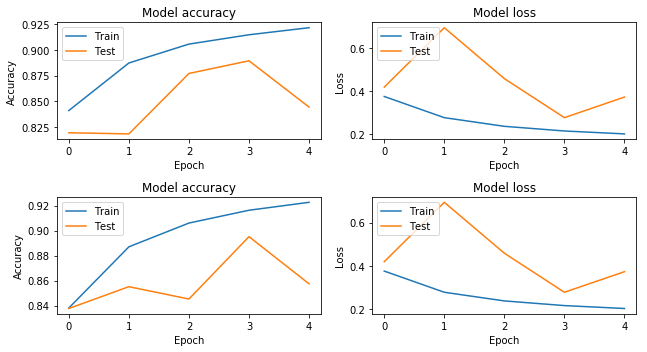

In [199]:

historyBatchBefore = means[0]
plt.figure(figsize=(9,5))

plt.subplot(2, 2, 1)
# Plot training & validation accuracy values
plt.plot(historyBatchBefore['acc'])
plt.plot(historyBatchBefore['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

plt.subplot(2, 2, 2)

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

historyBatchAfter = means[1]

plt.subplot(2,2,3)
# Plot training & validation accuracy values
plt.plot(historyBatchAfter['acc'])
plt.plot(historyBatchAfter['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
xs = [];
ys = [];
times = [];
for i in range(1, 11):
    gc.collect();
    y_train_subset = y_train[:int((len(X_train)/10) * i)]
    X_train_subset = X_train[:int((len(X_train)/1091) * i)]
    model = batchBefore()
    start_time = time.time();
    model.fit(X_train_subset, y_train_subset,epochs=5, batch_size=32, callbacks=[TQDMNotebookCallback()], verbose=0)
    score = model.evaluate(X_test, y_test, batch_size=32)
    xs.append(i * 10);
    ys.append(score)
    times.append(time.time() - start_time)
    

In [ ]:
ys

In [17]:
z = batchBefore()

In [18]:
z.metrics_names

['loss', 'acc']

In [82]:
# caching from other notebook
xs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ys = [[0.3375332970108676, 0.8564286688178885],
 [0.3293629326703429, 0.8648366131891105],
 [0.5694290703417445, 0.7891651138481116],
 [0.7749491917055851, 0.7836658637458528],
 [0.336175938627912, 0.8522928691406616],
 [0.994924304453139, 0.7673044585018967],
 [0.2400954164402412, 0.9011498432221621],
 [0.22097328733323526, 0.910375857824023],
 [0.2286083311565799, 0.9059219197436353],
 [0.7929028012517072, 0.9043582939958323]]
decisionYs = [0.5134435316436542, 0.5745254325436161, 
              0.5453134543164626, 0.5854262654274613, 
              0.5954623654275464, 0.5464353254637411, 
              0.6016344253768487, 0.6363447587598674, 
              0.6612697386754643, 0.6745365375395623]
boostingY = [0.49983219895391852, 0.5138847390187585, 
              0.5005498029588590, 0.5183705841036052, 
              0.5231069410663139, 0.5443301930503013, 
              0.5743598338850385, 0.6112378434157855, 
              0.6612697386754643, 0.6564223157753243]
kNNY = [0.4374819840624884, 0.4934100239593562, 
        0.5045431587048912, 0.5001020394006202, 
        0.5331990401825637, 0.4489520812395820, 
        0.5182939050123983, 0.5313755816002983, 
        0.4982370304672290, 0.5448900128395810]
SVMy = [0.47447201884504075, 0.5046718914746082, 
        0.5016246562546889, 0.4582748666459793, 
        0.4477714602915569, 0.5041805276804852, 
        0.4682776883697699, 0.44208344224584517, 
        0.49422385876121694, 0.4995442189399771]

In [83]:
newYs = []
for elem in ys:
    newYs.append(elem[1])
print(newYs)

[0.8564286688178885, 0.8648366131891105, 0.7891651138481116, 0.7836658637458528, 0.8522928691406616, 0.7673044585018967, 0.9011498432221621, 0.910375857824023, 0.9059219197436353, 0.9043582939958323]


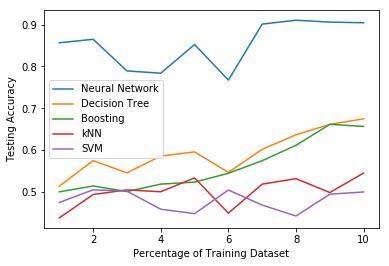

In [84]:
plt.plot(xs, newYs)
plt.plot(xs, decisionYs)
plt.plot(xs, boostingY)
plt.plot(xs, kNNY)
plt.plot(xs, SVMy)
plt.xlabel("Percentage of Training Dataset")
plt.ylabel("Testing Accuracy")
plt.legend(["Neural Network", "Decision Tree", "Boosting", "kNN", "SVM"])